# Table of Contents
 <p><div class="lev2"><a href="#GPU設定"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>GPU設定</a></div><div class="lev2"><a href="#データのロード"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>データのロード</a></div><div class="lev2"><a href="#学習パラメータの設定"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>学習パラメータの設定</a></div><div class="lev2"><a href="#モデルの定義"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>モデルの定義</a></div><div class="lev2"><a href="#Optimizerの設定"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Optimizerの設定</a></div><div class="lev2"><a href="#訓練の実行"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>訓練の実行</a></div><div class="lev2"><a href="#結果の可視化"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>結果の可視化</a></div><div class="lev2"><a href="#Convolution層のフィルタを可視化"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Convolution層のフィルタを可視化</a></div><div class="lev1"><a href="#オートエンコーダー（一般画像）"><span class="toc-item-num">1&nbsp;&nbsp;</span>オートエンコーダー（一般画像）</a></div>

In [5]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
from PIL import Image
from StringIO import StringIO
import math

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import six
import tables

import matplotlib.pyplot as plt


## GPU設定

In [3]:
gpu_flag = 1
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## データのロード

In [6]:
## 刺激画像
fileStimuli = "../DataSet/Stimuli.mat"
dataStimuli = tables.openFile(fileStimuli)
imgStimuli = dataStimuli.get_node('/st')[:]
imgStimuliVd = dataStimuli.get_node('/sv')[:]
print 'DataShape [Stimuli] : {}'.format(imgStimuli.shape)
print 'DataShape [Stimuli for varidation] : {}'.format(imgStimuliVd.shape)

/home/tokita/.pyenv/versions/anaconda2-2.4.1/envs/ch1.8/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: openFile() is pending deprecation, use open_file() instead. You may use the pt2to3 tool to update your source code.
  app.launch_new_instance()


DataShape [Stimuli] : (108000, 3, 128, 128)
DataShape [Stimuli for varidation] : (8100, 3, 128, 128)


In [7]:
## 15fpsで映像を見せているので、とりあえず15枚ずつ間引く
train_x= imgStimuli[np.arange(0, imgStimuli.shape[0], 15)]
train_x = train_x.astype(np.float32)
### テストデータ
test_x= imgStimuliVd[np.arange(0, imgStimuliVd.shape[0], 15)]
test_x = test_x.astype(np.float32)

## データの正規化
train_x = train_x / 255
test_x = test_x / 255
print 'train_x.shape={}'.format(train_x.shape)
print 'test_x.shape={}'.format(test_x.shape)

N_train = train_x.shape[0]
N_test = test_x.shape[0]
print('N_train={}, N_test={}'.format(N_train, N_test))


train_x.shape=(7200, 3, 128, 128)
test_x.shape=(540, 3, 128, 128)
N_train=7200, N_test=540


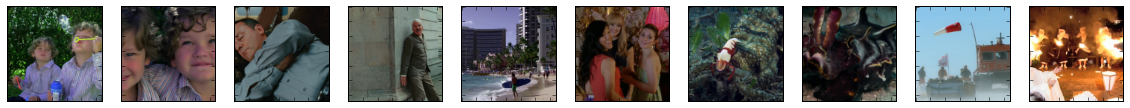

In [35]:
def draw_img_rgb(data, size=128):
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    data /= data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        tmp = data[idx,:,:,:].transpose(2,1,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
#draw_img_rgb( train_x[np.random.permutation( test_x.shape[0] )[:7]] )
idx = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
draw_img_rgb( test_x[idx] )

## 学習パラメータの設定

In [ ]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 10     # epoch数
n_latent = 100   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
conv_size = 512  # convolution層の最大チャネルサイズ

# Optimizer(Adam)
al = 0.001
b1 = 0.9
b2 = 0.999

size = 128

# モデルの出力インターバル
model_interval = 100
# モデルファイルの出力先
out_model_dir = './out/out_models_test'
try:
    os.mkdir(out_model_dir)
except:
    pass

## モデルの定義

In [18]:
class AE(chainer.Chain):
    """AutoEncoder"""
    def __init__(self, n_latent=100, input_size=96, input_ch=3, output_ch=512):
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.input_size = input_size
        self.out_size = input_size/(2**4)
        super(AE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            c0 = L.Convolution2D(self.input_ch, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.input_ch)),
            c1 = L.Convolution2D(self.output_ch/8, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            c2 = L.Convolution2D(self.output_ch/4, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            c3 = L.Convolution2D(self.output_ch/2, self.output_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            l4 = L.Linear(self.out_size*self.out_size*self.output_ch, n_latent, wscale=0.02*math.sqrt(self.out_size*self.out_size*self.output_ch)),
            bne0 = L.BatchNormalization(self.output_ch/8),
            bne1 = L.BatchNormalization(self.output_ch/4),
            bne2 = L.BatchNormalization(self.output_ch/2),
            bne3 = L.BatchNormalization(self.output_ch),
            # decoder
            l0z = L.Linear(n_latent, self.out_size*self.out_size*self.output_ch, wscale=0.02*math.sqrt(n_latent)),
            dc1 = L.Deconvolution2D(self.output_ch, self.output_ch/2, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch)),
            dc2 = L.Deconvolution2D(self.output_ch/2, self.output_ch/4, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/2)),
            dc3 = L.Deconvolution2D(self.output_ch/4, self.output_ch/8, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/4)),
            dc4 = L.Deconvolution2D(self.output_ch/8, self.input_ch, 4, stride=2, pad=1, wscale=0.02*math.sqrt(4*4*self.output_ch/8)),
            bnd0l = L.BatchNormalization(self.out_size*self.out_size*self.output_ch),
            bnd0 = L.BatchNormalization(self.output_ch),
            bnd1 = L.BatchNormalization(self.output_ch/2),
            bnd2 = L.BatchNormalization(self.output_ch/4),
            bnd3 = L.BatchNormalization(self.output_ch/8),
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x), sigmoid)

    def encode(self, x, test=False):
        # 推論モデル, 中間表現のベクトルqを学習
        h = F.relu(self.bne0(self.c0(x)))
        h = F.relu(self.bne1(self.c1(h), test=test))
        h = F.relu(self.bne2(self.c2(h), test=test))
        h = F.relu(self.bne3(self.c3(h), test=test))
        z = F.tanh(self.l4(h))
        return z

    def decode(self, z, sigmoid=True, test=False):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h = F.reshape(F.relu(self.bnd0l(self.l0z(z), test=test)), (z.data.shape[0], self.output_ch, self.out_size, self.out_size))
        h = F.relu(self.bnd1(self.dc1(h), test=test))
        h = F.relu(self.bnd2(self.dc2(h), test=test))
        h = F.relu(self.bnd3(self.dc3(h), test=test))
        x = (self.dc4(h))
        if sigmoid:
            return F.sigmoid(x)
        else:
            return x

    def get_loss_func(self, train=True):
        def lf(x):
            z = self.encode(x)
            batchsize = len(x.data)
            # reconstruction loss
            #self.rec_loss = F.mean_squared_error(x, self.decode(z))
            self.rec_loss = F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (batchsize)
            # total_loss vanilla AEの場合はreconstruction lossとtotal lossは一緒
            self.loss = self.rec_loss
            return self.loss
        return lf

## Optimizerの設定

In [19]:
# モデルの設定
model = AE(input_size=size, n_latent=n_latent, output_ch=conv_size)
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 訓練の実行

In [21]:
loss_arr = []
print "epoch, train_mean_loss"
for epoch in six.moves.range(1, n_epoch + 1):
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N_train)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N_train, batchsize):
        x = chainer.Variable(xp.asarray(train_x[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        model.zerograds()
        loss = model.get_loss_func()(x)
        loss.backward()
        optimizer.update()
        
        sum_loss += float(model.loss.data) * len(x.data)

    print('{}, {}'.format(epoch, sum_loss / N_train))
    loss_arr.append(float(sum_loss)/N_train)
    
    # モデルの保存
    if epoch%model_interval==0:
        serializers.save_hdf5("%s/model_AE_%05d.h5"%(out_model_dir, epoch), model)
# モデルの保存(最終モデル)
if epoch%model_interval!=0:
    serializers.save_hdf5("%s/model_AE_%05d.h5"%(out_model_dir, epoch), model)

epoch, train_mean_loss
1, 27432.7761502
2, 27363.6530219
3, 27338.8403049
4, 27326.4473741
5, 27281.6837023
6, 27217.783827
7, 27168.5645616
8, 27194.5352648
9, 27105.4393175
10, 27092.5743273


IOError: Unable to create file (Unable to open file: name = './out/out_models_test/model_ae_00010.h5', errno = 2, error message = 'no such file or directory', flags = 13, o_flags = 242)

## 結果の可視化

[]

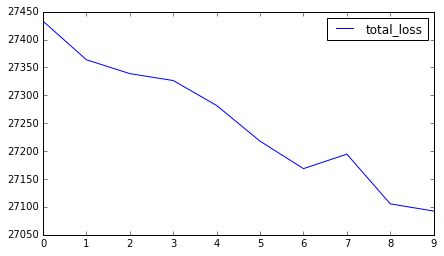

In [22]:
plt.figure(figsize=(7, 4))
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF", label="total_loss")
plt.legend()
plt.plot()

[5189 4616 5712 2777 6739 4079 3071 3431 6623 6228]
input image


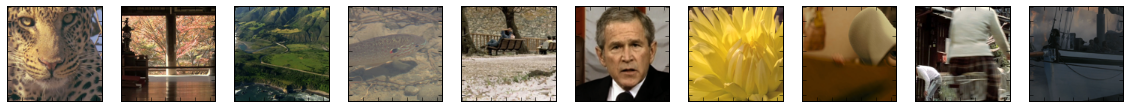

reconstruction image


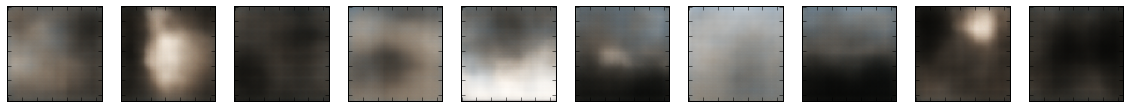

In [25]:
## 描画テスト (Closed test)
test_ind = np.random.permutation(N_train)[:10]
print test_ind
test = chainer.Variable(xp.asarray(train_x[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_rgb(train_x[test_ind])

print "reconstruction image"
draw_img_rgb(y.data.get())


[370 130  54 129 287 513 224 522 218 391]
input image


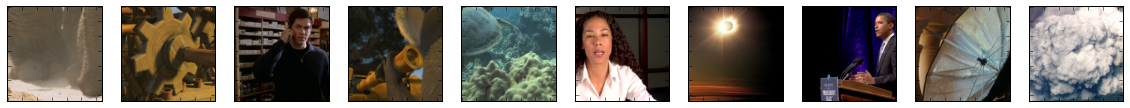

reconstruction image


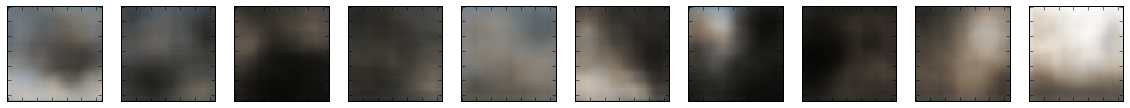

In [26]:
## 描画テスト (Open test) 
test_ind = np.random.permutation(N_test)[:10]
print test_ind
test = chainer.Variable(xp.asarray(test_x[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_rgb(test_x[test_ind])

print "reconstruction image"
draw_img_rgb(y.data.get())

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
input image


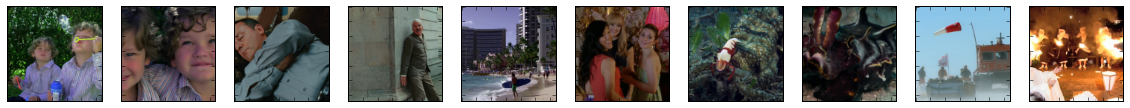

reconstruction image


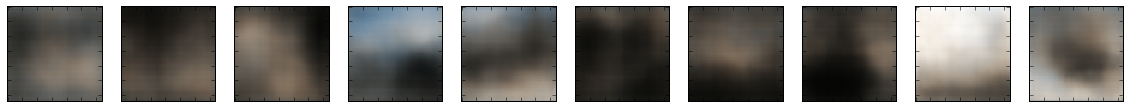

In [36]:
## 描画テスト (Open test, 固定画像) 
#test_ind = np.arange(70,80)
test_ind = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
print test_ind
test = chainer.Variable(xp.asarray(test_x[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_rgb(test_x[test_ind])

print "reconstruction image"
draw_img_rgb(y.data.get())

decode image from random vector


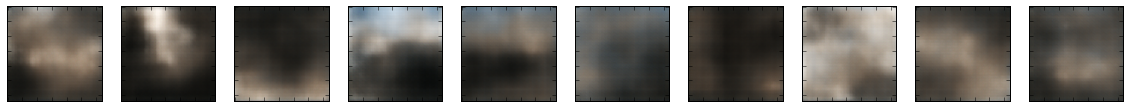

In [28]:
# draw images from randomly sampled z
z = chainer.Variable(xp.random.normal(0, 1, (10, n_latent)).astype(np.float32))
x = model.decode(z)
print "decode image from random vector"
draw_img_rgb(x.data.get())

## Convolution層のフィルタを可視化

In [ ]:
def draw_img_filter(data):
    size = data.shape[3]
    n = data.shape[0]
    n_col = int(math.ceil(n / 15)+1)
    img_data = data.get()
    plt.figure(figsize=(10*2, n_col*2))
    img_data /= img_data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(n_col, 15, cnt)
        tmp = img_data[idx,:,:,:].transpose(1,2,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()

In [ ]:
# 入力層側
draw_img_filter(model.c0.W.data)

In [ ]:
# 出力層側
draw_img_filter(model.dc4.W.data)

In [ ]:
np.arange(5,15)

# オートエンコーダー（一般画像）

# Table of Contents
 <p><div class="lev2"><a href="#GPU設定"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>GPU設定</a></div><div class="lev2"><a href="#データのロード"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>データのロード</a></div><div class="lev2"><a href="#学習パラメータの設定"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>学習パラメータの設定</a></div><div class="lev2"><a href="#モデルの定義"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>モデルの定義</a></div><div class="lev2"><a href="#Optimizerの設定"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Optimizerの設定</a></div><div class="lev2"><a href="#訓練の実行"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>訓練の実行</a></div><div class="lev2"><a href="#結果の可視化"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>結果の可視化</a></div><div class="lev2"><a href="#Convolution層のフィルタを可視化"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Convolution層のフィルタを可視化</a></div><div class="lev1"><a href="#オートエンコーダー（一般画像）"><span class="toc-item-num">1&nbsp;&nbsp;</span>オートエンコーダー（一般画像）</a></div>

# Table of Contents
 <p><div class="lev2"><a href="#GPU設定"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>GPU設定</a></div><div class="lev2"><a href="#データのロード"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>データのロード</a></div><div class="lev2"><a href="#学習パラメータの設定"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>学習パラメータの設定</a></div><div class="lev2"><a href="#モデルの定義"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>モデルの定義</a></div><div class="lev2"><a href="#Optimizerの設定"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Optimizerの設定</a></div><div class="lev2"><a href="#訓練の実行"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>訓練の実行</a></div><div class="lev2"><a href="#結果の可視化"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>結果の可視化</a></div><div class="lev2"><a href="#Convolution層のフィルタを可視化"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Convolution層のフィルタを可視化</a></div><div class="lev1"><a href="#オートエンコーダー（一般画像）"><span class="toc-item-num">1&nbsp;&nbsp;</span>オートエンコーダー（一般画像）</a></div>